#Exploring the nuclear landscape
Here we'll implement a simple liquid drop model.  The coefficients were obtained from an online fitting tool that was part of the UNEDF SciDAC; unfortunately, that site no longer exists.

First, we'll set up our workspace.

In [1]:
from __future__ import division, print_function
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

We'll then define a class that holds our simple liquid-drop expression with 5 parameters (volume, surface, asymmetry, couloumb, and pairing).  This class will compute the binding energy (`BE`), the binding energy per nucleon (`BEper`), and the proton-separation, neutron-separation, two-proton-separation, and two-neutron-separation energies (`Sp`, `Sn`, `S2p`, `S2n`).

In [37]:
class nuclearDrop:
    def __init__(self,aV=-15.67,aS=17.04,aA=23.09,aC=0.71,aP=-14.55):
        self.aV = aV
        self.aS = aS
        self.aA = aA
        self.aC = aC
        self.aP = aP
    
    def delta(self,Z,N):
        """
        Computes the pairing term: +1 for even-even, -1 for odd-odd, 0 otherwise
        Z, N are either both scaler or both array-like.
        """
        # scalar check
        if (np.isscalar(Z)):
            if (Z%2 == 0 and N%2 == 0):
                d = 1
            elif (Z%2 == 0 or N%2 == 0):
                d = 0
            else:
                d = -1
        else:
            d = np.zeros(len(Z))
            d[np.where((Z%2 == 0) & (N%2 == 0))] = 1
            d[np.where((Z%2 != 0) & (N%2 != 0))] = -1
        return d
    
    def BE(self,Z,N):
        """
        Binding energy
        """
        A = Z+N
        A13 = A**(1/3)
        A23 = A**(2/3)
        aV, aS, aA, aC, aP = self.aV, self.aS, self.aA, self.aC, self.aP
        
        return -(aV*A + aS*A23 + aA*(N-Z)**2/A + aC*Z**2/A13 + aP*self.delta(Z,N)/A**(1/2))
    
    def BEper(self,Z,N):
        """
        Binding energy per nucleon
        """
        return self.BE(Z,N)/(Z+N)

    def dBE(self,Z,N,dZ,dN):
        return self.BE(Z,N)-self.BE(Z-dZ,N-dN)
    
    def Sp(self,Z,N):
        """
        Proton separation energy
        """
        return self.dBE(Z,N,1,0)
    
    def Sn(self,Z,N):
        """
        Neutron separation energy
        """
        return self.dBE(Z,N,0,1)
    
    def S2p(self,Z,N):
        """
        Two proton separation energy
        """
        return self.dBE(Z,N,-2,0)
    
    def S2n(self,Z,N):
        """
        Two neutron separation energy
        """
        return self.dBE(Z,N,0,-2)

Sometimes it is useful to ignore pairing. For convenience, we'll extend this class using a 4 parameter fit.  Our new class, `nuclearDropNoPairing`, inherits all the functions of the 5-parameter model.  In addition, because the fit is now a differentiable function of $N$ and $Z$ we can find the $Z$ that maximizes the binding energy for fixed $A$:
\begin{equation}
    \left.\frac{d(BE)}{dZ}\right|_A = -4a_A\frac{(A-2Z)}{A} + 2a_C \frac{Z}{A^{1/3}}.
\end{equation}
Setting the derivative to 0 and solving for $Z$ gives
\begin{equation}
    Z_\star = \frac{A}{2}\left(1 + \frac{a_C}{4a_A}A^{2/3}\right)^{-1}
\end{equation}
We'll implement this function in the class as well.

In [38]:
class nuclearDropNoPairing(nuclearDrop):
    def __init__(self,aV=-15.5,aS=16.6,aA=22.7,aC=0.71):
        nuclearDrop.__init__(self,aV=aV,aS=aS,aA=aA,aC=aC,aP=0.0)

    def Zstar(self,A):
        """
        Charge number Z s.t. the binding energy is minized for a given A.
        A can either be a scalar or array-like.
        """
        ZS = 0.5*A/(1.0+0.25*self.aC*A**(2/3)/self.aA)
        return np.round(ZS)

## Some examples

BE/A(56Fe) =  8.893 (pairing);  8.805 (no pairing) 6.306950682183002


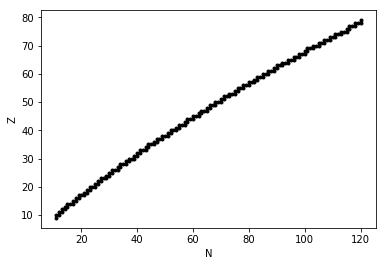

In [50]:
ld = nuclearDrop()
ldnp = nuclearDropNoPairing()
print('BE/A(56Fe) = {0:6.3f} (pairing); {1:6.3f} (no pairing)'.\
      format(ld.BEper(26,30),ldnp.BEper(26,30)),ld.BEper(2,2))
A = np.arange(20,200)
Zs = ldnp.Zstar(A)
Ns = A-Zs
plt.plot(Ns,Zs,'k.')
plt.xlabel('N')
plt.ylabel('Z')

In [73]:
ld.BEper(6,6)

7.646749846198787

In [67]:
ld.BE(82,126)

1641.5097663608929

In [66]:
-3*ld.BE(2,2)+ld.BE(6,6)

16.077589968189415